In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io

In [82]:
# First let's load the data and take a look at the first few rows.


# Downloading the csv file from my GitHub account

url = "https://raw.githubusercontent.com/timshilstone/marketing_analysis/main/Campaign_Analysis/data/marketing.csv"
download = requests.get(url).content


# Reading the downloaded content and turning it into a pandas dataframe

marketing = pd.read_csv(io.StringIO(download.decode('utf-8')),parse_dates=['date_served','date_subscribed','date_canceled'])


# Printing out the first 5 rows of the dataframe
marketing.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaT,House Ads,True
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaT,House Ads,True
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaT,House Ads,True
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaT,House Ads,True
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaT,House Ads,True


In [85]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              10037 non-null  object        
 1   date_served          10021 non-null  datetime64[ns]
 2   marketing_channel    10022 non-null  object        
 3   variant              10037 non-null  object        
 4   converted            10022 non-null  object        
 5   language_displayed   10037 non-null  object        
 6   language_preferred   10037 non-null  object        
 7   age_group            10037 non-null  object        
 8   date_subscribed      1856 non-null   datetime64[ns]
 9   date_canceled        577 non-null    datetime64[ns]
 10  subscribing_channel  1856 non-null   object        
 11  is_retained          1856 non-null   object        
dtypes: datetime64[ns](3), object(9)
memory usage: 941.1+ KB


In [ ]:
# First let's transform the datatypes for a few columns

In [86]:
marketing['converted'] = marketing['converted'].astype('bool')

In [87]:
marketing['is_retained'].fillna(False,inplace=True)
marketing['is_retained'] = marketing['is_retained'].astype('bool')

# Feature Engineering

In [ ]:
# Next let's code the categorical data in 'subscribing_channel' to numerical values.

In [89]:
channel_dict = {"House Ads": 1, "Instagram": 2, 
                "Facebook": 3, "Email": 4, "Push": 5}

In [90]:
marketing['channel_code'] = marketing['subscribing_channel'].map(channel_dict)

In [ ]:
# Let's create a new column that identifies if the advertisement displayed the correct language. 

In [91]:
marketing['is_correct_lang'] = np.where(marketing['language_displayed']==marketing['language_preferred'],'Yes','No')

In [ ]:
# Finally let's create a column that stores the date of the week the ad was served (0=monday,1=tuesday,sunday=6 etc.)

In [92]:
marketing['DoW_served'] = marketing['date_subscribed'].dt.dayofweek

In [ ]:
# Here are the new columns we created.

In [151]:
marketing.loc[:,'channel_code':'DoW_served']

,channel_code,is_correct_lang,DoW_served
0,1.0,Yes,0.0
1,1.0,Yes,0.0
2,1.0,Yes,0.0
3,1.0,Yes,0.0
4,1.0,Yes,0.0
...,...,...,...
10032,4.0,Yes,2.0
10033,4.0,Yes,2.0
10034,4.0,Yes,2.0
10035,4.0,Yes,2.0


# Exploratory Analysis

In [ ]:
# Let's start with a very high level view of our campaign. Let's see how many unique people we reached over time.

In [94]:
daily_users = marketing.groupby('date_served')['user_id'].nunique()

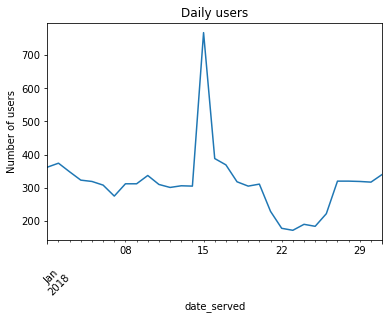

In [95]:
daily_users.plot()

plt.title('Daily users')
plt.ylabel('Number of users')

plt.xticks(rotation=45)

plt.show()

In [96]:
# Looks like we reached significantly more people mid month. 

#### Retention Rate

In [ ]:
# Next let's look at a high level retention rate 

In [97]:
# Calculate the number of subscribers (people that converted)
total_subscribers = marketing[marketing['converted']==True]['user_id'].nunique()

# Calculate the number of people who remained subscribed after one month of subscription
retained = marketing[marketing['is_retained']== True]['user_id'].nunique()

# Calculate the retention rate
retention_rate = retained/total_subscribers
print(round(retention_rate*100, 2), "%")

65.83 %


#### Conversion Rate

In [98]:
# Now let's look a the overall conversion rate

# Calculate the number of people we marketed to
total = marketing['user_id'].nunique()

# Calculate the number of people who subscribed
subscribers = marketing[marketing['converted'] == True]['user_id'].nunique()

# Calculate the conversion rate
conversion_rate = subscribers/total
print(round(conversion_rate*100, 2), "%")

14.09 %


In [99]:
# Is this a good conversion rate? This will depend heavily on the business. There is no particular number that 
# all marketing teams are trying to reach. Instead, it helps to look at benchmarks and historical data to determine 
# whether a conversion rate is what you would expect.

In [100]:
# Let's also look at conversion rate based on language displayed

# Group by language_displayed and count unique users
total = marketing.groupby(['language_displayed'])['user_id'].nunique()

# Group by language_displayed and count unique conversions
subscribers = marketing[marketing['converted'] == True].groupby(['language_displayed'])['user_id'].nunique()

# Calculate the conversion rate for all languages
language_conversion_rate = subscribers/total

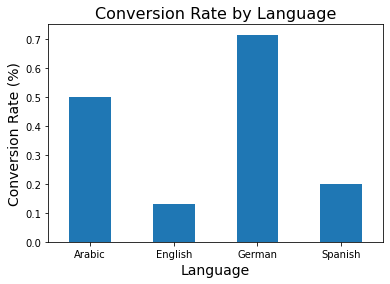

In [101]:
# Let's plot this data to a bar chart for analysis

language_conversion_rate.plot(kind='bar')

# Add a title and x and y-axis labels
plt.title('Conversion Rate by Language', size = 16)
plt.xticks(rotation=0)
plt.xlabel('Language', size = 14)
plt.ylabel('Conversion Rate (%)', size = 14)

# Display the plot
plt.show()

In [152]:
# Now let's analyze how the conversion rate changed based on when in the month the ad was served.

# Group by date_served and count unique users
total = marketing.groupby(['date_served'])['user_id'].nunique()

# Group by date_served and count unique converted users
subscribers = marketing[marketing['converted']==True].groupby(['date_served'])['user_id'].nunique()

# Calculate the conversion rate per day
daily_conversion_rate = subscribers/total

In [104]:
# Reset index to turn the results into a DataFrame
daily_conversion_rate = pd.DataFrame(daily_conversion_rate.reset_index())

# Rename columns
daily_conversion_rate.columns = ['date_subscribed', 
                              'conversion_rate']

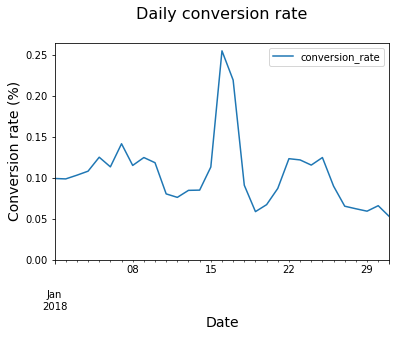

In [105]:
# Create a line chart using daily_conversion_rate for analysis.
daily_conversion_rate.plot(x='date_subscribed',y='conversion_rate')

plt.title('Daily conversion rate\n', size = 16)
plt.ylabel('Conversion rate (%)', size = 14)
plt.xlabel('Date', size = 14)

# Set the y-axis to begin at 0
plt.ylim(0)

# Display the plot
plt.show()

In [ ]:
# Interesting, conversion rates increased along with the impression spike mid month.

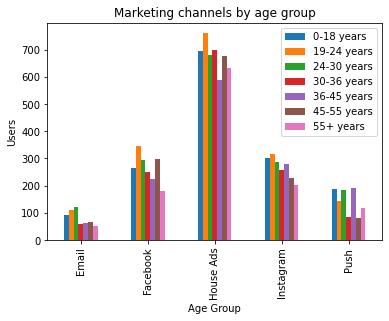

In [106]:
# Now let's take a look at campaign reach by marketing channel and age group
channel_age = marketing.groupby(['marketing_channel', 'age_group'])\
                                ['user_id'].count()

# Unstack channel_age and transform it into a DataFrame
channel_age_df = pd.DataFrame(channel_age.unstack(level = 1))

# Plot channel_age_df
channel_age_df.plot(kind = 'bar')
plt.title('Marketing channels by age group')
plt.xlabel('Age Group')
plt.ylabel('Users')
# Add a legend to the plot
plt.legend(loc = 'upper right', 
           labels = channel_age_df.columns.values)
plt.show()

In [ ]:
# Now let take a look at retenion rates by channel over time

In [107]:
# Count the subs by subscribing channel and day
retention_total = marketing.groupby(['date_subscribed',
                                     'subscribing_channel'])['user_id'].nunique()

# Print results
print(retention_total.head(10))

date_subscribed  subscribing_channel
2018-01-01       Email                   1
                 Facebook                8
                 House Ads              16
                 Instagram               8
                 Push                    3
2018-01-02       Email                   4
                 Facebook                6
                 House Ads              17
                 Instagram               8
                 Push                    2
Name: user_id, dtype: int64


In [155]:
# Sum the retained subs by subscribing channel and date subscribed
retention_subs = marketing[marketing['is_retained']==True].groupby(['date_subscribed','subscribing_channel'])['user_id'].nunique()

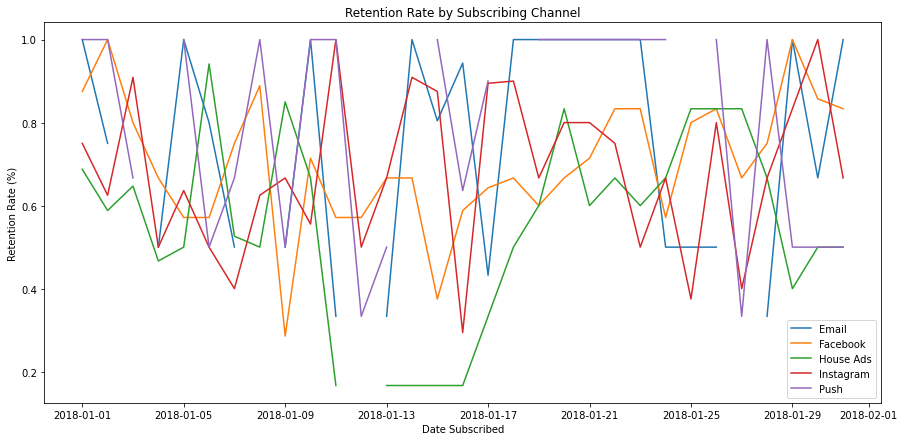

In [156]:
# Divide retained subscribers by total subscribers
retention_rate = retention_subs/retention_total
retention_rate_df = pd.DataFrame(retention_rate.unstack(level=1))

# Plot retention rate
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(retention_rate_df)

# Add a title, x-label, y-label, legend and display the plot
plt.title('Retention Rate by Subscribing Channel')
plt.xlabel('Date Subscribed')
plt.ylabel('Retention Rate (%)')
plt.legend(labels=retention_rate_df.columns.values,loc='lower right')
plt.show()

In [ ]:
# Hm, that's pretty challenging to read. With more time I'd plot each channel to it's own chart.

In [110]:
# Because the work above was a bit repetative let's automate some of the code with functions for conversion rates

In [111]:
def conversion_rate(dataframe, column_names):
    
    # Total number of converted users
    column_conv = dataframe[dataframe['converted'] == True]\
                       .groupby(column_names)['user_id'].nunique()

    # Total number users
    column_total = dataframe.groupby(column_names)['user_id'].nunique()   
    
    # Conversion rate 
    conversion_rate = column_conv/column_total
    
    # Fill missing values with 0
    conversion_rate = conversion_rate.fillna(0)
    
    return conversion_rate

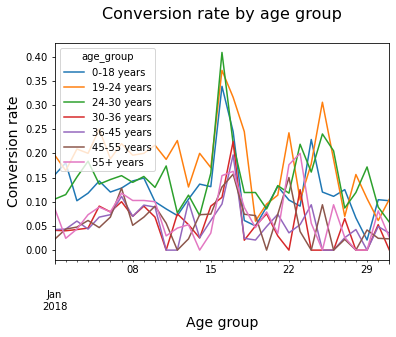

In [112]:
# Calculate conversion rate by age_group
age_group_conv = conversion_rate(marketing, ['date_served', 'age_group'])

# Unstack and create a DataFrame
age_group_df = pd.DataFrame(age_group_conv.unstack())

# Visualize conversion by age_group
age_group_df.plot()
plt.title('Conversion rate by age group\n', size = 16)
plt.ylabel('Conversion rate', size = 14)
plt.xlabel('Age group', size = 14)
plt.show()

In [113]:
# Great our funciton is working but this chart is difficult to read. Let's build another function to plot each group 
# on their own chart. 

In [114]:
def plotting_conv(dataframe):
    for column in dataframe:
        figure, ax = plt.subplots(figsize=(15,5))
        # Plot column by dataframe's index
        ax.plot(dataframe.index,dataframe[column])
        plt.title('Daily ' + str(column) + ' conversion rate\n', 
                  size = 16)
        plt.ylabel('Conversion rate', size = 14)
        plt.xlabel('Date', size = 14)
        # Show plot
        plt.show()  
        plt.clf()

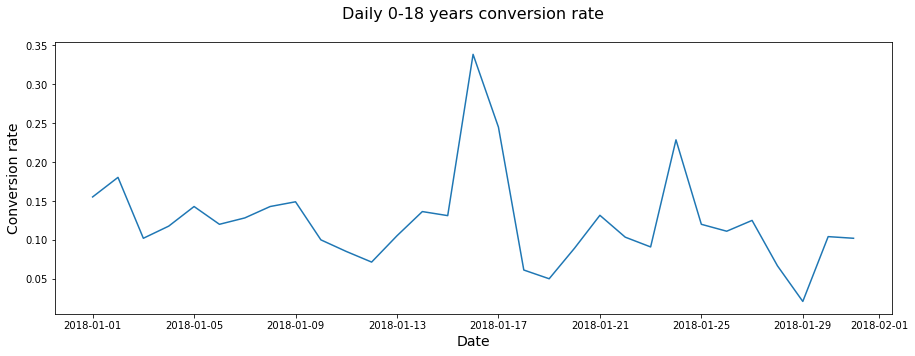

<Figure size 432x288 with 0 Axes>

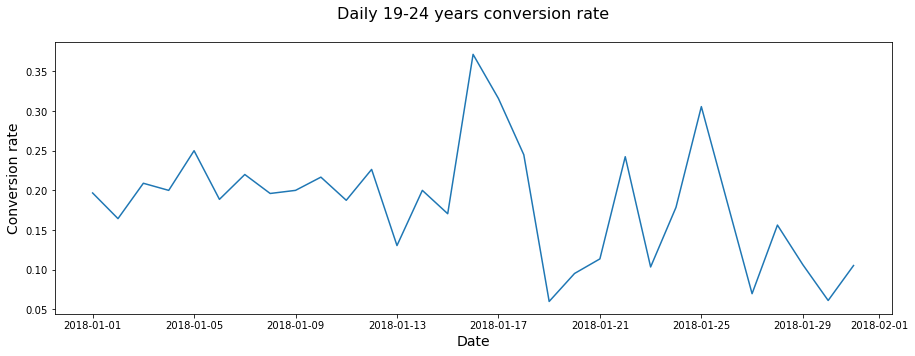

<Figure size 432x288 with 0 Axes>

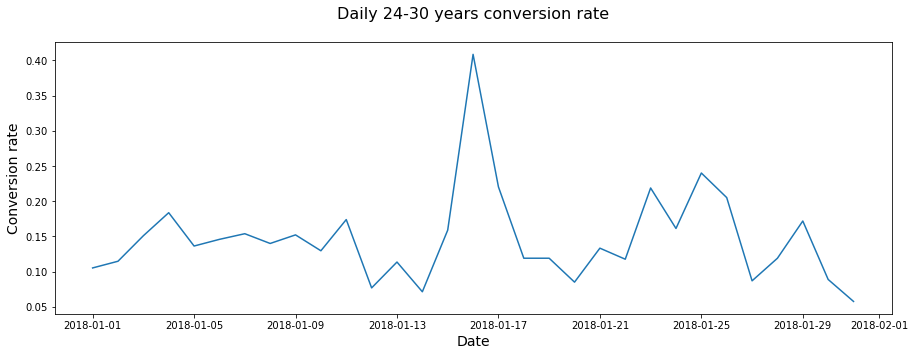

<Figure size 432x288 with 0 Axes>

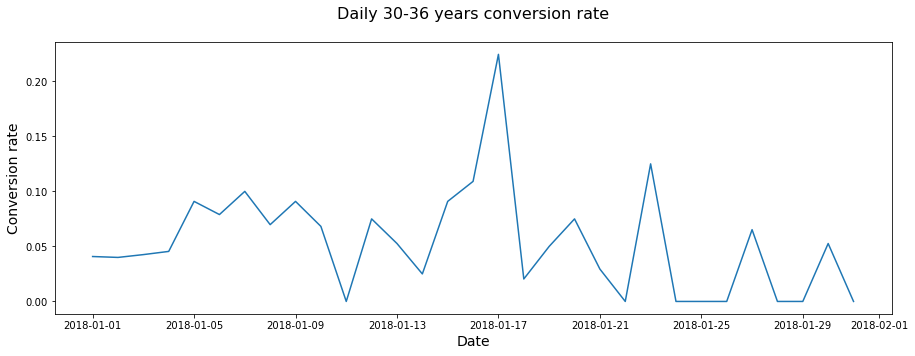

<Figure size 432x288 with 0 Axes>

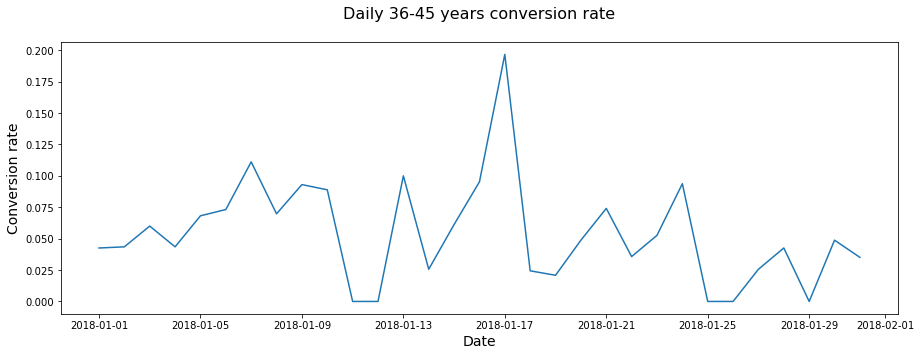

<Figure size 432x288 with 0 Axes>

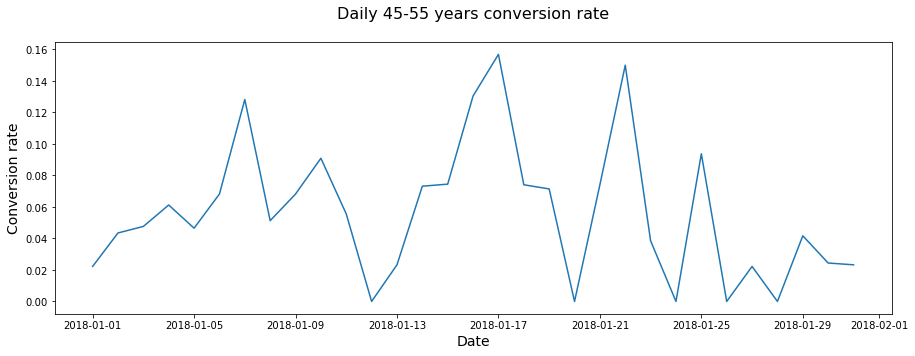

<Figure size 432x288 with 0 Axes>

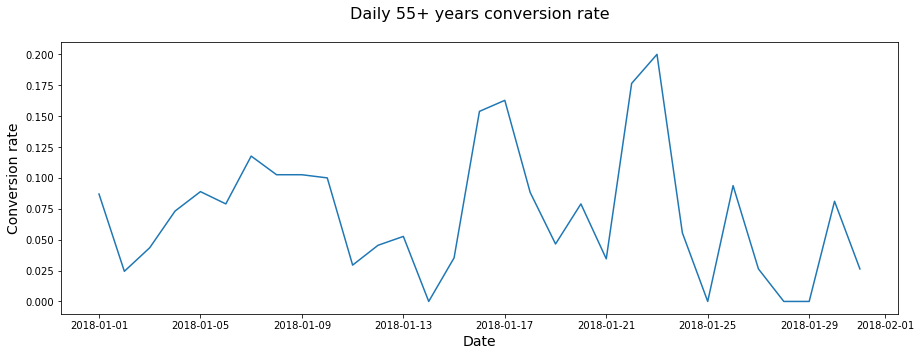

<Figure size 432x288 with 0 Axes>

In [115]:
plotting_conv(age_group_df)

In [116]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(marketing,['date_served','marketing_channel'])

print(daily_conv_channel.head())

date_served  marketing_channel
2018-01-01   Email                1.000000
             Facebook             0.117647
             House Ads            0.084656
             Instagram            0.106667
             Push                 0.083333
Name: user_id, dtype: float64


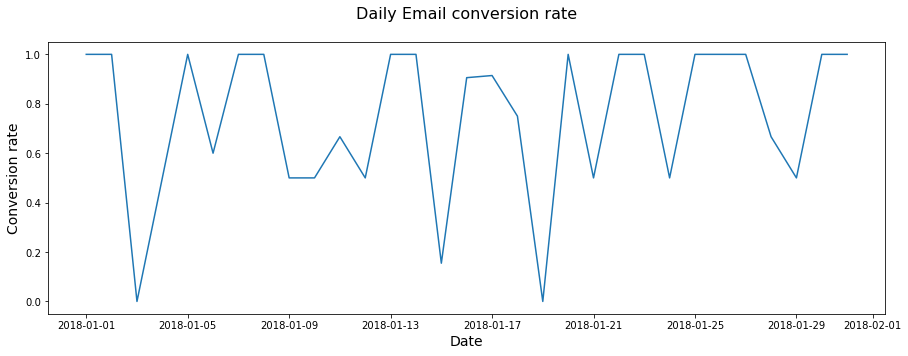

<Figure size 432x288 with 0 Axes>

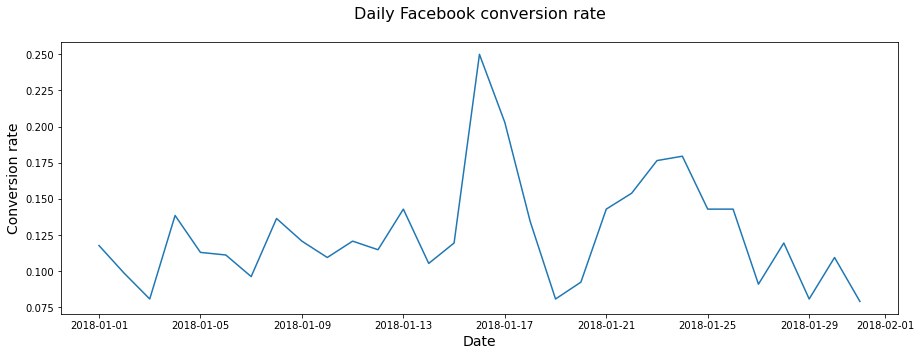

<Figure size 432x288 with 0 Axes>

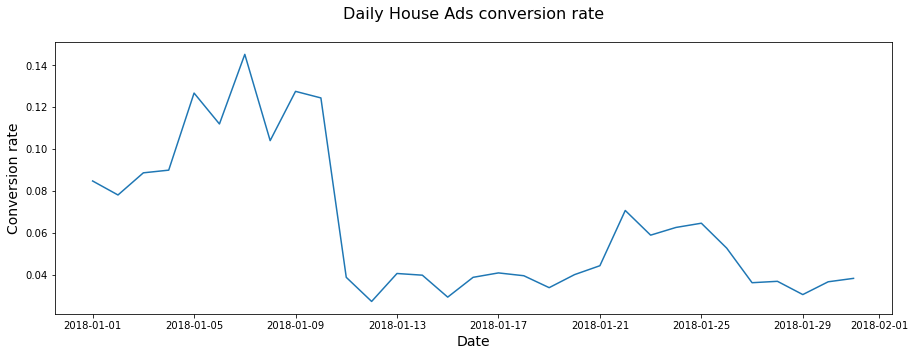

<Figure size 432x288 with 0 Axes>

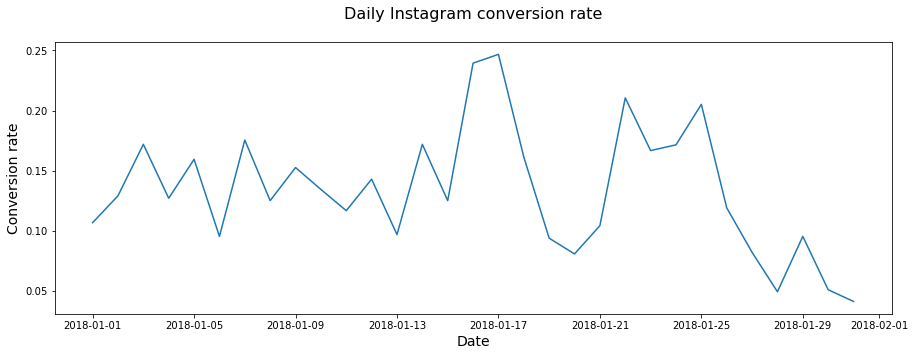

<Figure size 432x288 with 0 Axes>

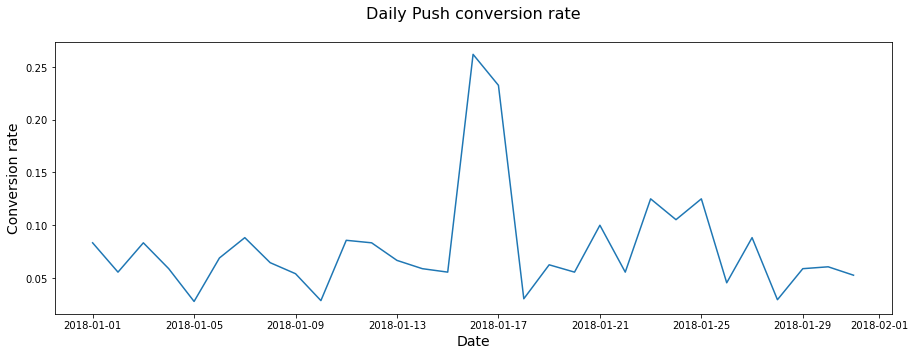

<Figure size 432x288 with 0 Axes>

In [117]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(marketing, ['date_served', 
                                                 'marketing_channel'])

# Unstack daily_conv_channel and convert it to a DataFrame
daily_conv_channel = pd.DataFrame(daily_conv_channel.unstack(level = 1))

# Plot results of daily_conv_channel
plotting_conv(daily_conv_channel)

In [118]:
# Great! This is much easier to both read and code. Interesting results too, it looks like House Ads have seen a 
# decrease in conversion rate since around Jan 11th. Let's dive into this a bit more to see if we can understand 
# the cause of this.

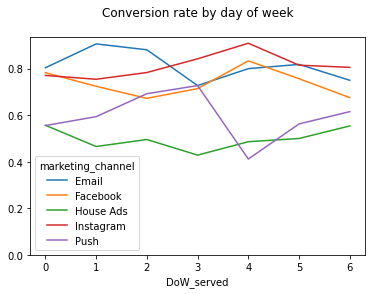

In [119]:
# Let's start by calculating the conversion rate by day of week
DoW_conversion = conversion_rate(marketing, ['DoW_served', 'marketing_channel'])


# Unstack channels
DoW_df = pd.DataFrame(DoW_conversion.unstack(level=1))

# Plot conversion rate by day of week
DoW_df.plot()
plt.title('Conversion rate by day of week\n')
plt.ylim(0)
plt.show()

In [ ]:
# House ads conversions are fairly stable by day of the week.

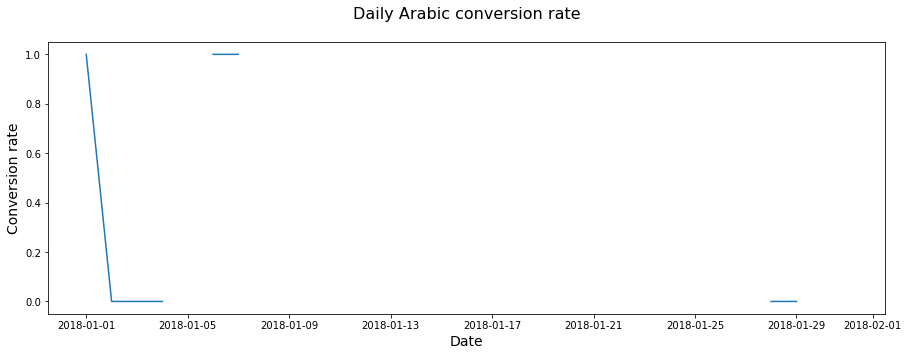

<Figure size 432x288 with 0 Axes>

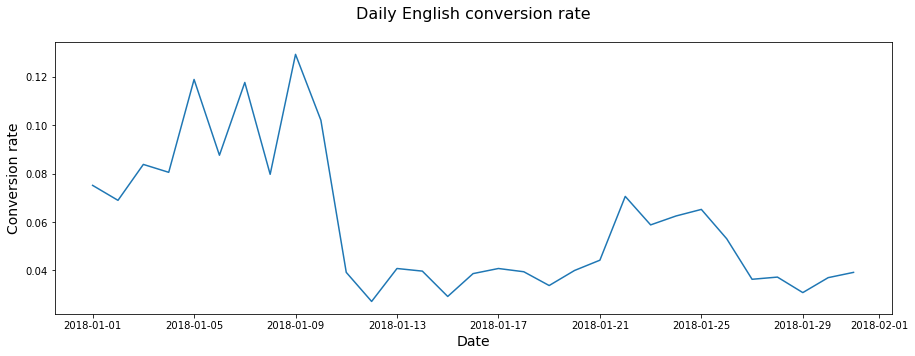

<Figure size 432x288 with 0 Axes>

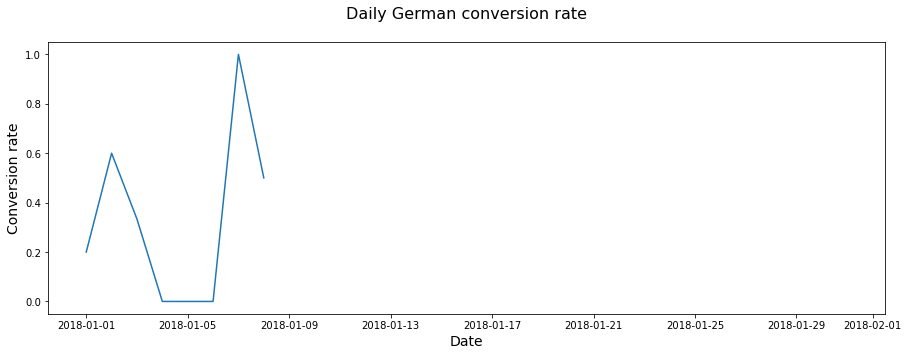

<Figure size 432x288 with 0 Axes>

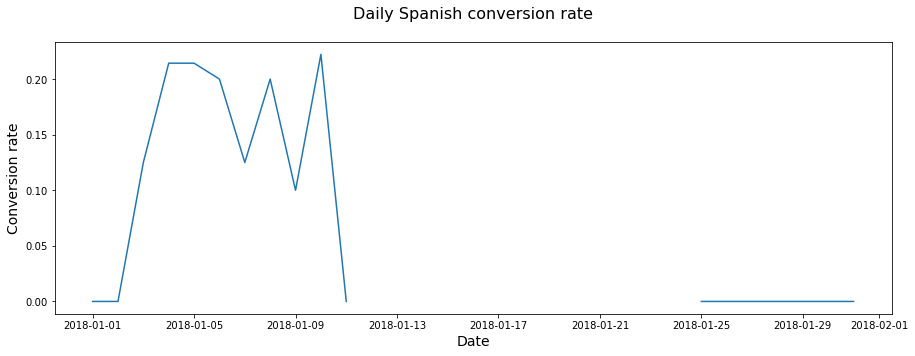

<Figure size 432x288 with 0 Axes>

In [120]:
# Let's dive into checking conversion rates by language. First, isolate the rows where marketing channel is House Ads.
house_ads = marketing[marketing['marketing_channel']=='House Ads']

# Calculate conversion by date served, and language displayed
conv_lang_channel = conversion_rate(house_ads,['date_served','language_displayed'])

# Unstack conv_lang_channel
conv_lang_df = pd.DataFrame(conv_lang_channel.unstack(level=1))

# Use your plotting function to display results
plotting_conv(conv_lang_df)

In [121]:
# Interesting. As you can see, the English conversion rate drops around the 11th, and there do not appear to be 
# ads served in other languages for a two week period. Let's investigate further.

In [122]:
# Perhaps correct_language will be the cause of the problem. Groupby date_served and correct_language.
language_check = house_ads.groupby(['date_served','is_correct_lang'])['user_id'].count()

# Unstack language_check and fill missing values with 0's
language_check_df = pd.DataFrame(language_check.unstack(level=1)).fillna(0)

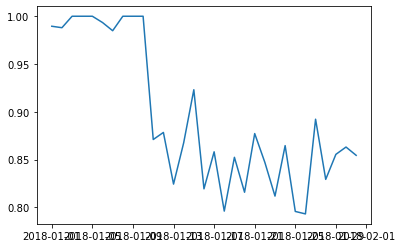

In [123]:
# Divide the count where language is correct by the row sum
language_check_df['pct'] = language_check_df['Yes']/language_check_df.sum(axis=1)

# Plot and show your results
plt.plot(language_check_df.index.values, language_check_df['pct'])
plt.show()

In [124]:
# As you can see as the conversion rates drop the number of people receiving an ad in the right language decreases.

In [125]:
# Great! This has shown that house ads have been underperforming due to serving all ads in English rather 
# than each user's preferred language.

#### Measuring Impact of Error

In [126]:
# Calculate pre-error conversion rate
house_ads_bug = house_ads[house_ads['date_served'] < '2018-01-11']
lang_conv = conversion_rate(house_ads_bug,'language_displayed')

# Index other language conversion rate against English
spanish_index = lang_conv['Spanish']/lang_conv['English']
arabic_index = lang_conv['Arabic']/lang_conv['English']
german_index = lang_conv['German']/lang_conv['English']

print("Spanish index:", spanish_index)
print("Arabic index:", arabic_index)
print("German index:", german_index)

Spanish index: 1.681924882629108
Arabic index: 5.045774647887324
German index: 4.485133020344287


In [127]:
# This shows us that each of these countries convert at a multiple shown compared to English users.
# To understand the true impact of the bug, it is crucial to determine how many subscribers we would have expected 
# had there been no language error. This is crucial to understanding the scale of the problem and how important 
# it is to prevent this kind of error in the future.

In [128]:
# Group house_ads by date and language
converted = house_ads.groupby(['date_served','language_preferred'])\
                        .agg({'user_id':'nunique',
                              'converted':'sum'})

# Unstack converted
converted = pd.DataFrame(converted.unstack(level=1))

In [129]:
# Create English conversion rate column for affected period
converted['english_conv_rate'] = converted.loc['2018-01-11':'2018-01-31'][('converted','English')]

# Create expected conversion rates for each language
converted['expected_spanish_rate'] = converted['english_conv_rate']*spanish_index
converted['expected_arabic_rate'] = converted['english_conv_rate']*arabic_index
converted['expected_german_rate'] = converted['english_conv_rate']*german_index

# Multiply number of users by the expected conversion rate
converted['expected_spanish_conv'] = converted['expected_spanish_rate']/100*converted[('user_id','Spanish')]
converted['expected_arabic_conv'] = converted['expected_arabic_rate']/100*converted[('user_id','Arabic')]
converted['expected_german_conv'] = converted['expected_german_rate']/100*converted[('user_id','German')]

In [130]:
converted

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01             2.0   171.0    5.0    11.0       2.0    13.0    1.0   
2018-01-02             3.0   200.0    5.0    10.0       0.0    14.0    3.0   
2018-01-03             2.0   179.0    3.0     8.0       0.0    15.0    1.0   
2018-01-04             2.0   149.0    2.0    14.0       0.0    12.0    0.0   
2018-01-05             NaN   143.0    1.0    14.0       NaN    17.0    0.0   
2018-01-06             3.0   136.0    2.0    11.0       3.0    12.0    0.0   
2018-01-07             2.0   117.0    2.0    10.0       2.0    14.0    2.0   
2018-01-08             NaN   138.0    6.0    10.0       NaN    11.0    3.0   
2018-01-09             NaN   147.0    NaN    10.0       NaN    19.0    NaN   
2018-01-10             NaN   147.0    4.0    18.0       NaN    15.0    2.0   
2018-01-11             7.0   133.0    2.0    13.0       0.0     6.0    0.0   
2018-01-12             3.0   129.0    4.0    11.0       0.0     3.0    0.0   
2018-01-13             6.0   121.0    5.0    16.0       0.0     5.0    1.0   
2018-01-14             5.0   131.0    3.0    12.0       0.0     6.0    0.0   
2018-01-15             2.0   189.0    4.0    10.0       0.0     6.0    0.0   
2018-01-16             7.0   127.0    4.0    17.0       0.0     6.0    0.0   
2018-01-17             2.0   126.0    3.0    16.0       0.0     2.0    0.0   
2018-01-18             7.0   121.0    6.0    18.0       0.0     5.0    1.0   
2018-01-19             5.0   126.0    5.0    12.0       1.0     4.0    0.0   
2018-01-20             6.0   124.0    6.0    14.0       1.0     4.0    1.0   
2018-01-21             1.0    99.0    4.0     9.0       0.0     5.0    0.0   
2018-01-22             2.0    72.0    3.0     8.0       1.0     4.0    1.0   
2018-01-23             3.0    69.0    4.0     9.0       0.0     5.0    0.0   
2018-01-24             2.0    83.0    3.0     8.0       0.0     6.0    0.0   
2018-01-25             3.0    75.0    4.0    11.0       0.0     4.0    2.0   
2018-01-26             6.0    89.0    3.0    16.0       0.0     4.0    0.0   
2018-01-27             3.0   148.0    3.0    12.0       1.0     4.0    0.0   
2018-01-28             5.0   134.0    3.0    21.0       0.0     4.0    0.0   
2018-01-29             7.0   138.0    4.0    15.0       2.0     3.0    0.0   
2018-01-30             4.0   139.0    3.0    18.0       0.0     4.0    0.0   
2018-01-31             7.0   130.0    4.0    16.0       1.0     4.0    0.0   

                           english_conv_rate expected_spanish_rate  \
language_preferred Spanish                                           
date_served                                                          
2018-01-01             0.0               NaN                   NaN   
2018-01-02             0.0               NaN                   NaN   
2018-01-03             1.0               NaN                   NaN   
2018-01-04             3.0               NaN                   NaN   
2018-01-05             3.0               NaN                   NaN   
2018-01-06             2.0               NaN                   NaN   
2018-01-07             1.0               NaN                   NaN   
2018-01-08             2.0               NaN                   NaN   
2018-01-09             1.0               NaN                   NaN   
2018-01-10             4.0               NaN                   NaN   
2018-01-11             0.0               6.0             10.091549   
2018-01-12             1.0               3.0              5.045775   
2018-01-13             0.0               5.0              8.409624   
2018-01-14             0.0               6.0             10.091549   
2018-01-15             0.0               6.0             10.091549   
2018-01-16             0.0               6.0             10.091549   
2018-01-17             4.0          

In [131]:
# Use .loc to slice only the relevant dates
converted = converted.loc['2018-01-11':'2018-01-31']

# Sum expected subscribers for each language
expected_subs = converted['expected_spanish_conv'].sum() + converted['expected_arabic_conv'].sum() + converted['expected_german_conv'].sum()

# Calculate how many subscribers we actually got
actual_subs = converted[('converted','Spanish')].sum() + converted[('converted','Arabic')].sum() + converted[('converted','German')].sum()

# Subtract how many subscribers we got despite the bug
lost_subs = expected_subs - actual_subs
print(lost_subs)

32.14414319248826


In [132]:
# Great! 32 subscribers may not seem like many, but for a small company this can be vitally important, 
# especially when expanding to new markets.

### A/B Testing

In [ ]:
# Now let's analyze our email A/B test results and check for significance.

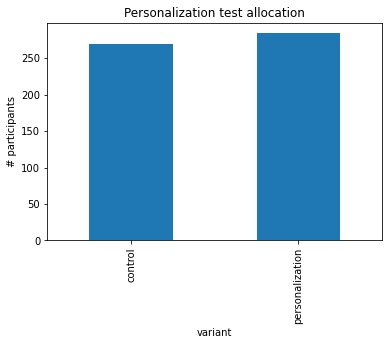

In [133]:
# First, let's check for allocation. subset the DataFrame 
email = marketing[marketing['marketing_channel'] == 'Email']

# Group the email DataFrame by variant 
alloc = email.groupby(['variant'])['user_id'].nunique()

# Plot a bar chart of the test allocation
alloc.plot(kind='bar')
plt.title('Personalization test allocation')
plt.ylabel('# participants')
plt.show()

In [134]:
# Now that we know allocation is relatively even let's look at the conversion rate for the control and 
# personalization. Since we chose conversion rate as our key metrics for this test, it is highly important that we 
# evaluate whether or not conversion was higher in the personalization treatment compared with the control.

In [135]:
# Group marketing by user_id and variant
subscribers = email.groupby(['user_id', 
                             'variant'])['converted'].max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1)) 

# Drop missing values from the control column
control = subscribers_df['control'].dropna()

# Drop missing values from the personalization column
personalization = subscribers_df['personalization'].dropna()

print('Control conversion rate:', control.mean())
print('Personalization conversion rate:', personalization.mean())

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


In [136]:
# Great! The treatment conversion rate is higher than the control. Let's look into the lift. 
# The result of the lift equation is the percent difference between the control and treatment.

#### Calculating lift = treatement conversion rate - control conversion rate / control conversion rate 

In [ ]:
# To calculate lift let's create a function.

In [137]:
def lift(a,b):
    # Calcuate the mean of a and b
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    
    # Calculate the lift using a_mean and b_mean
    lift = (b_mean-a_mean)/a_mean
  
    return str(round(lift*100, 2)) + '%'
  
# Print lift() with control and personalization as inputs
print(lift(control, personalization))

38.85%


In [138]:
# As you can see, there's a large lift, but are these results statistically significant? Statistical significance 
# is vital to understanding whether a test showed a positive result by chance or if it is reflective of a true 
# difference between the variants. This will enable our marketing team to make an informed choice about whether 
# to roll out the feature or not.

#### The threshold for a statistically significant result is when p is less than 0.05

In [139]:
from scipy.stats import ttest_ind

In [140]:
t = ttest_ind(control, personalization)
print(t)

Ttest_indResult(statistic=-2.7343299447505074, pvalue=0.006451487844694175)


In [141]:
# Awesome, because the p value is less than 0.05 we can be confident the difference in conversion rates is 
# statistically significant! Next it is important to check how new features are affecting specific demographics. 
# Again let's create a function to make exploring results easier to code.

In [142]:
def ab_segmentation(segment):
  # Build a for loop for each segment in marketing
  for subsegment in np.unique(marketing[segment].values):
      print(subsegment)
      
      # Limit marketing to email and subsegment      
      email = marketing[(marketing['marketing_channel'] == 'Email') & (marketing[segment] == subsegment)]

      subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
      subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
      control = subscribers['control'].dropna()
      personalization = subscribers['personalization'].dropna()

      print('lift:', lift(control, personalization))
      print('t-statistic:', ttest_ind(control, personalization), '\n\n')

In [143]:
ab_segmentation('age_group')

0-18 years
lift: 121.4%
t-statistic: Ttest_indResult(statistic=-2.966044912142211, pvalue=0.0038724494391297226) 


19-24 years
lift: 106.24%
t-statistic: Ttest_indResult(statistic=-3.03179438478667, pvalue=0.0030623836114689134) 


24-30 years
lift: 161.19%
t-statistic: Ttest_indResult(statistic=-3.861539544326876, pvalue=0.00018743381094867337) 


30-36 years
lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.1859064644147996, pvalue=0.0023238487431765137) 


36-45 years
lift: -85.23%
t-statistic: Ttest_indResult(statistic=2.4317901279318503, pvalue=0.01797568600978829) 


45-55 years
lift: -72.22%
t-statistic: Ttest_indResult(statistic=2.065499127317933, pvalue=0.043062339688201196) 


55+ years
lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.3265654564203397, pvalue=0.0016358623456360435) 




In [144]:
# This shows us that personalization was extremely effective for younger groups but less effective than the control 
# for older groups. One explanation might be that younger users understand how their data might be used online and 
# think personalization is cool because it gives them more insight into themselves while older people might feel that 
# this is a violation of their privacy.

In [145]:
ab_segmentation('language_displayed')

Arabic
lift: 50.0%
t-statistic: Ttest_indResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001) 


English
lift: 39.0%
t-statistic: Ttest_indResult(statistic=-2.2183598646203166, pvalue=0.026991701290720815) 


German
lift: -1.62%
t-statistic: Ttest_indResult(statistic=0.1910083418078718, pvalue=0.8494394170062678) 


Spanish
lift: 166.67%
t-statistic: Ttest_indResult(statistic=-2.3570226039551585, pvalue=0.040156718110477524) 




In [ ]:
# And looking at the A/B test by language displayed we can see that Spanish users saw the greatest lift in the 
# personalization efforts. English saw a good lift as well. German and Arabic p values are over 0.05 
# so the results may be due to chance, and thus are not significant.